<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Import the packege

In [137]:
import shap
import time
import logging
import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression, RFECV
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import wilcoxon, bootstrap
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from scipy.stats import wilcoxon, bootstrap, uniform, randint


warnings.filterwarnings('ignore')

## logging fit

In [90]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## seed

In [91]:
SEED = 42  
np.random.seed(SEED)

# Custom transformer for outlier clipping

In [92]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.lower_bounds = {}
        self.upper_bounds = {}
    
    def fit(self, X, y=None):
        # Convert X to DataFrame if it's a NumPy array
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.columns)
        
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.lower_bounds[col] = Q1 - 1.5 * IQR
            self.upper_bounds[col] = Q3 + 1.5 * IQR
        return self
    
    def transform(self, X, y=None):
        # Convert X to DataFrame if it's a NumPy array
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.columns)
        
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = X_copy[col].clip(lower=self.lower_bounds[col], upper=self.upper_bounds[col])
        return X_copy

# read data set

In [93]:
df_xlsx = pd.read_excel('../data/DummyData.xlsx')

df_xlsx.to_csv('../data/DummyData.csv', index=False)
logger.info("change the xlsx form csv file done! ")
df = pd.read_csv('../data/DummyData.csv')
df.shape
logger.info('read the csv file')
df_original = df.copy()
logger.info("copy data set done!")

2025-06-08 08:08:01,534 - INFO - change the xlsx form csv file done! 
2025-06-08 08:08:01,558 - INFO - read the csv file
2025-06-08 08:08:01,564 - INFO - copy data set done!


In [94]:
df.head()

,sex,age,educational_status,partner_status,employment_status,weight,height,BMI,treatment,EMI,...,nitrate,diuretic,psychotropic,angiotensin2_receptor_blocker,week,steps,mvpa_mins,perception,steps_goal,mvpa_mins_goal
0,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,72765,2105,16,95047.0,2509.0
1,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,53817,1557,2,74490.0,2063.0
2,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,58911,1704,4,70379.0,2163.0
3,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,85157,2463,8,125754.0,3164.0
4,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,51341,1485,12,68819.0,1886.0


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sex                            566 non-null    int64  
 1   age                            564 non-null    float64
 2   educational_status             561 non-null    float64
 3   partner_status                 561 non-null    float64
 4   employment_status              561 non-null    float64
 5   weight                         561 non-null    float64
 6   height                         561 non-null    float64
 7   BMI                            561 non-null    float64
 8   treatment                      561 non-null    float64
 9   EMI                            559 non-null    float64
 10  EAP                            559 non-null    float64
 11  EPTCA                          559 non-null    float64
 12  ECABG                          559 non-null    flo

In [96]:
df.describe()

,sex,age,educational_status,partner_status,employment_status,weight,height,BMI,treatment,EMI,...,nitrate,diuretic,psychotropic,angiotensin2_receptor_blocker,week,steps,mvpa_mins,perception,steps_goal,mvpa_mins_goal
count,566.000000,564.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,559.000000,...,561.000000,561.000000,561.000000,561.000000,561.000000,566.000000,566.000000,566.000000,531.000000,530.000000
mean,1.526502,48.753546,1.909091,0.520499,1.522282,77.306595,170.602496,26.537683,0.898396,0.157424,...,0.119430,0.160428,0.119430,0.155080,3.522282,42170.001767,1023.332155,5.328622,55226.549906,1260.035849
std,0.499739,14.723789,0.806628,0.500025,0.499949,15.792022,10.074398,4.984085,0.835815,0.364526,...,0.324583,0.367330,0.324583,0.362304,1.925381,22804.693283,624.349263,4.213101,30099.992532,773.527674
min,1.000000,25.000000,1.000000,0.000000,1.000000,46.000000,150.000000,17.170000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,2145.000000,5.000000,0.000000,3089.000000,6.000000
25%,1.000000,36.000000,1.000000,0.000000,1.000000,64.000000,164.000000,22.940000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,23264.000000,604.250000,2.000000,30682.500000,716.250000
50%,2.000000,47.000000,2.000000,1.000000,2.000000,78.000000,170.000000,26.300000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,42602.000000,961.000000,5.000000,54642.000000,1153.500000
75%,2.000000,62.000000,3.000000,1.000000,2.000000,90.000000,178.000000,29.970000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,58830.250000,1400.750000,8.000000,77647.500000,1743.750000
max,2.000000,75.000000,3.000000,1.000000,2.000000,106.000000,190.000000,38.540000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,8.000000,102990.000000,2745.000000,20.000000,143791.000000,3617.000000


In [97]:
df.columns

Index(['sex', 'age', 'educational_status', 'partner_status',
       'employment_status', 'weight', 'height', 'BMI', 'treatment', 'EMI',
       'EAP', 'EPTCA', 'ECABG', 'ECVA_TIA', 'riskfactor_familyhistory',
       'riskfactor_DM', 'riskfactor_hypertension', 'riskfactor_dyslipidemia',
       'riskfactor_smoking', 'acetylsalicylic_acid',
       'cholesterol_lowering_med', 'ACE_inhibitor', 'calcium_blocker',
       'beta_blocker', 'thienopyridine', 'oral_anticoagulant', 'nitrate',
       'diuretic', 'psychotropic', 'angiotensin2_receptor_blocker', 'week',
       'steps', 'mvpa_mins', 'perception', 'steps_goal', 'mvpa_mins_goal'],
      dtype='object')

In [98]:
df = df.dropna(subset=['steps_goal', 'mvpa_mins_goal'])
logger.info("Deleted rows with missing targets")
print(f"THis is the shape of data {df.shape}")

2025-06-08 08:08:16,775 - INFO - Deleted rows with missing targets


THis is the shape of data (525, 36)


In [99]:
# Drop the 'week' column
df = df.drop('week', axis=1)
logger.info("Dropped the week column")

2025-06-08 08:08:17,991 - INFO - Dropped the week column


# Split features and targets

In [100]:
X = df.drop(['steps_goal', 'mvpa_mins_goal'], axis=1)
y = df[['steps_goal', 'mvpa_mins_goal']]

# Split data into train, validation, and holdout

In [101]:
X_temp, X_holdout, y_temp, y_holdout = train_test_split(X, y, test_size=0.15, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED)
logger.info("Data split into train, validation, and holdout")
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_holdout:", X_holdout.shape)

2025-06-08 08:08:39,487 - INFO - Data split into train, validation, and holdout


X_train: (356, 33) X_val: (90, 33) X_holdout: (79, 33)


In [102]:
numeric_columns = X.columns.tolist()
numeric_columns[:11]

['sex',
 'age',
 'educational_status',
 'partner_status',
 'employment_status',
 'weight',
 'height',
 'BMI',
 'treatment',
 'EMI',
 'EAP']

## Pipeline

In [103]:
numeric_transformer = Pipeline([
    ('imputer', IterativeImputer(max_iter=10, random_state=SEED)),
    ('clipper', OutlierClipper(columns=numeric_columns)),
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_regression, k=10))
])

preprocessor = Pipeline([
    ('numeric', numeric_transformer)
])
# Pipeline for XGBoost (no feature selection)
xgb_preprocessor = Pipeline([
    ('imputer', IterativeImputer(max_iter=10, random_state=SEED)),
    ('clipper', OutlierClipper(columns=numeric_columns)),
    ('scaler', StandardScaler())
])

#  Apply preprocessing

In [104]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train['steps_goal'])
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)

#  Get selected features for non-XGBoost models

In [105]:
selected_features_mask = preprocessor.named_steps['numeric'].named_steps['selector'].get_support()
selected_features = [numeric_columns[i] for i in range(len(numeric_columns)) if selected_features_mask[i]]
print("Selected features for non-XGBoost models:", selected_features)
logger.info("Feature selection completed for non-XGBoost models")

2025-06-08 08:11:24,620 - INFO - Feature selection completed for non-XGBoost models


Selected features for non-XGBoost models: ['partner_status', 'weight', 'height', 'BMI', 'treatment', 'riskfactor_hypertension', 'acetylsalicylic_acid', 'steps', 'mvpa_mins', 'perception']


# Apply preprocessing for XGBoost

In [106]:

X_train_xgb = xgb_preprocessor.fit_transform(X_train, y_train['steps_goal'])
X_val_xgb = xgb_preprocessor.transform(X_val)
X_holdout_xgb = xgb_preprocessor.transform(X_holdout)
logger.info("Preprocessing completed for XGBoost")

2025-06-08 08:11:54,255 - INFO - Preprocessing completed for XGBoost


## Correlation matrix

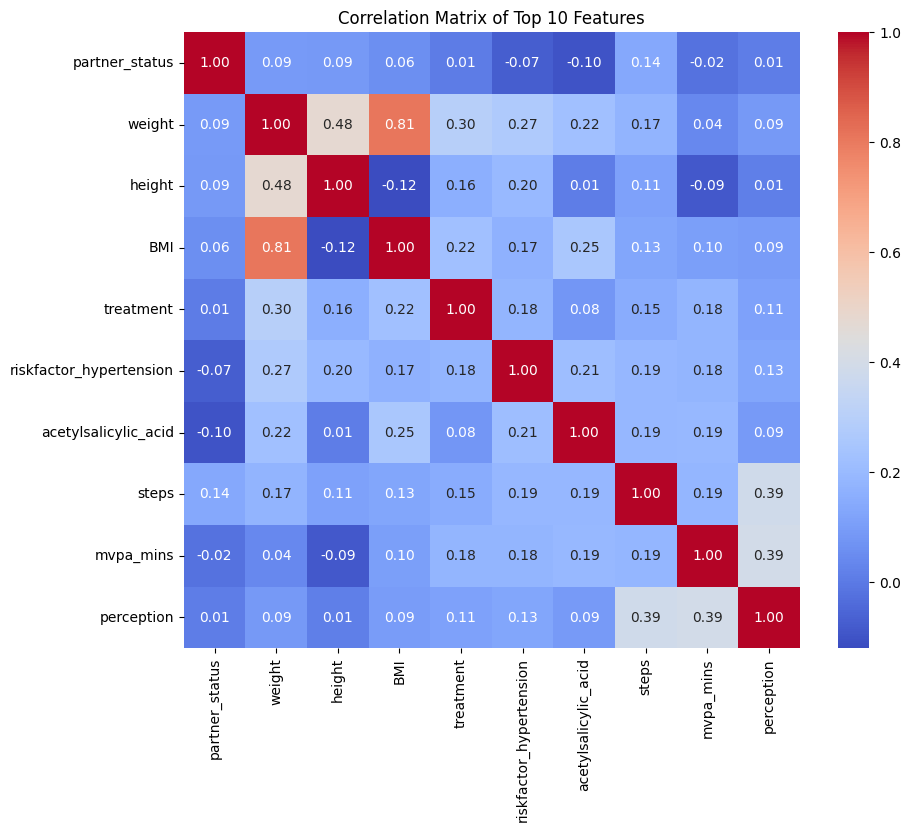

2025-06-08 08:12:41,907 - INFO - Correlation matrix saved as '../photo/correlation_matrix.png'


In [108]:
X_train_selected = pd.DataFrame(X_train_preprocessed, columns=selected_features)
correlation_matrix = X_train_selected.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Top 10 Features')
plt.savefig('../photo/correlation_matrix.png')
plt.show()
logger.info("Correlation matrix saved as '../photo/correlation_matrix.png'")

## Define models

In [109]:
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'KNN': KNeighborsRegressor(),
    'MLP': MLPRegressor(max_iter=1000, random_state=SEED),
    'ExtraTrees': ExtraTreesRegressor(random_state=SEED),
    'RandomForest': RandomForestRegressor(random_state=SEED),
    'GradientBoosting': GradientBoostingRegressor(random_state=SEED),
    'XGBoost': XGBRegressor(random_state=SEED),
}

# Cross-validation

In [110]:
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED)
results_cv = {}

for name, model in models.items():
    results_cv[name] = {}
    for target in ['steps_goal', 'mvpa_mins_goal']:
        logger.info(f"Training {name} for target: {target}")
        if name == 'XGBoost':
            pipeline = Pipeline([
                ('preprocessor', xgb_preprocessor),
                ('regressor', model)
            ])
            X_temp_cv = X_temp
        else:
            pipeline = Pipeline([	
                ('preprocessor', preprocessor),
                ('regressor', model)
            ])
            X_temp_cv = X_temp
        scores = cross_validate(
            pipeline, X_temp_cv, y_temp[target],
            scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
            cv=cv,
            return_train_score=False,
            n_jobs=-1
        )
        results_cv[name][f'{target}_R2'] = np.mean(scores['test_r2'])
        results_cv[name][f'{target}_MAE'] = -np.mean(scores['test_neg_mean_absolute_error'])
        results_cv[name][f'{target}_RMSE'] = np.sqrt(-np.mean(scores['test_neg_mean_squared_error']))
        
df_cv_results = pd.DataFrame(results_cv).T
df_cv_results = df_cv_results.sort_values(by=['steps_goal_R2'], ascending=False)
print(df_cv_results)

2025-06-08 08:13:50,528 - INFO - Training Linear for target: steps_goal


2025-06-08 08:14:16,644 - INFO - Training Linear for target: mvpa_mins_goal
2025-06-08 08:14:22,769 - INFO - Training Ridge for target: steps_goal
2025-06-08 08:14:29,656 - INFO - Training Ridge for target: mvpa_mins_goal
2025-06-08 08:14:35,179 - INFO - Training Lasso for target: steps_goal
2025-06-08 08:14:40,480 - INFO - Training Lasso for target: mvpa_mins_goal
2025-06-08 08:14:46,974 - INFO - Training ElasticNet for target: steps_goal
2025-06-08 08:14:53,501 - INFO - Training ElasticNet for target: mvpa_mins_goal
2025-06-08 08:14:59,761 - INFO - Training KNN for target: steps_goal
2025-06-08 08:15:06,925 - INFO - Training KNN for target: mvpa_mins_goal
2025-06-08 08:15:13,119 - INFO - Training MLP for target: steps_goal
2025-06-08 08:15:48,003 - INFO - Training MLP for target: mvpa_mins_goal
2025-06-08 08:16:21,948 - INFO - Training ExtraTrees for target: steps_goal
2025-06-08 08:16:31,928 - INFO - Training ExtraTrees for target: mvpa_mins_goal
2025-06-08 08:16:42,951 - INFO - Tra

                  steps_goal_R2  steps_goal_MAE  steps_goal_RMSE  \
Ridge                  0.963384     4276.646797      5613.921357   
Lasso                  0.963303     4281.397765      5617.869284   
Linear                 0.963263     4282.728217      5620.859203   
RandomForest           0.956047     4604.367118      6165.117328   
GradientBoosting       0.954114     4632.104435      6321.916571   
ExtraTrees             0.953177     4751.840477      6376.405266   
XGBoost                0.944654     5030.065180      6921.961482   
ElasticNet             0.854705     9297.789975     11378.087536   
KNN                    0.794401    10354.450976     13475.955486   
MLP                   -3.400955    54449.311103     61639.817344   

                  mvpa_mins_goal_R2  mvpa_mins_goal_MAE  mvpa_mins_goal_RMSE  
Ridge                      0.982322           76.295250           104.993673  
Lasso                      0.982541           75.660028           104.335405  
Linear        

# Plot R2 comparison

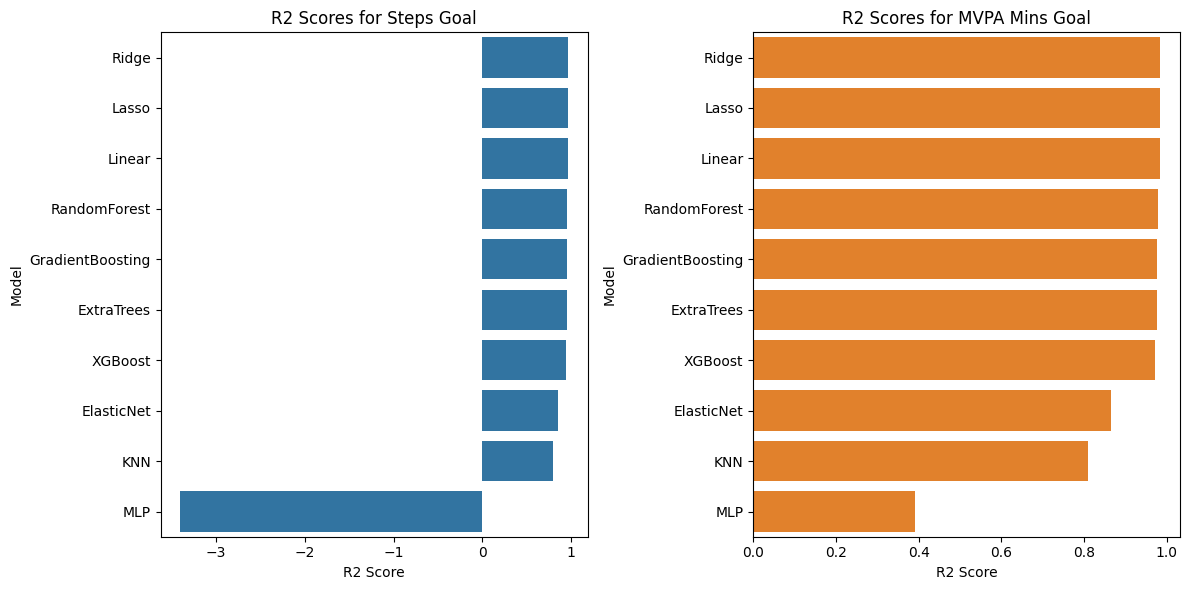

2025-06-08 08:18:14,422 - INFO - R2 comparison plots saved as '../photo/r2_comparison.png'


In [111]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=df_cv_results['steps_goal_R2'], y=df_cv_results.index, color='#1f77b4')
plt.title('R2 Scores for Steps Goal')
plt.xlabel('R2 Score')
plt.ylabel('Model')

plt.subplot(1, 2, 2)
sns.barplot(x=df_cv_results['mvpa_mins_goal_R2'], y=df_cv_results.index, color='#ff7f0e')
plt.title('R2 Scores for MVPA Mins Goal')
plt.xlabel('R2 Score')
plt.ylabel('Model')

plt.tight_layout()
plt.savefig('../photo/r2_comparison.png')
plt.show()
logger.info("R2 comparison plots saved as '../photo/r2_comparison.png'")

# Hyperparameter tuning for XGBoost GridSearchCV

In [112]:
pipeline_xgb = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=SEED))
])

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.8, 0.9, 1.0]
}


# GridSearchCV for steps_goal

In [113]:
grid_search_steps = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_search_steps.fit(X_temp, y_temp['steps_goal'])
print("Best params for steps_goal:", grid_search_steps.best_params_)
print("Best CV R2 for steps_goal:", grid_search_steps.best_score_)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Best params for steps_goal: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Best CV R2 for steps_goal: 0.9577268487086356


# Gridsearch for mvpa_mins_goal

In [114]:
grid_search_mvpa = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_search_mvpa.fit(X_temp, y_temp['mvpa_mins_goal'])
print("Best params for mvpa_mins_goal:", grid_search_mvpa.best_params_)
print("Best CV R2 for mvpa_mins_goal:", grid_search_mvpa.best_score_)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Best params for mvpa_mins_goal: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Best CV R2 for mvpa_mins_goal: 0.9777319917598479


# Evaluate on holdout set

In [115]:
est_model_steps = grid_search_steps.best_estimator_
y_holdout_pred_steps = est_model_steps.predict(X_holdout)
print("\nHoldout Set Evaluation for steps_goal:")
print("R2:", r2_score(y_holdout['steps_goal'], y_holdout_pred_steps))
print("MAE:", mean_absolute_error(y_holdout['steps_goal'], y_holdout_pred_steps))
print("RMSE:", np.sqrt(mean_squared_error(y_holdout['steps_goal'], y_holdout_pred_steps)))

est_model_mvpa = grid_search_mvpa.best_estimator_
y_holdout_pred_mvpa = est_model_mvpa.predict(X_holdout)
print("\nHoldout Set Evaluation for mvpa_mins_goal:")
print("R2:", r2_score(y_holdout['mvpa_mins_goal'], y_holdout_pred_mvpa))
print("MAE:", mean_absolute_error(y_holdout['mvpa_mins_goal'], y_holdout_pred_mvpa))
print("RMSE:", np.sqrt(mean_squared_error(y_holdout['mvpa_mins_goal'], y_holdout_pred_mvpa)))


Holdout Set Evaluation for steps_goal:
R2: 0.9657183850602966
MAE: 4199.868423655063
RMSE: 5635.115845343488

Holdout Set Evaluation for mvpa_mins_goal:
R2: 0.9824277221396311
MAE: 69.65156323396707
RMSE: 88.4124475073859


# Feature Importance Analysis

In [ ]:
# 1. XGBoost Feature Importance
xgb_model_steps = est_model_steps.named_steps['regressor']
xgb_model_mvpa = est_model_mvpa.named_steps['regressor']
X_preprocessed = xgb_preprocessor.transform(X_temp)



2025-06-08 09:47:19,393 - INFO - XGBoost feature importance for steps_goal saved as '../data/xgb_feature_importance_steps_goal.csv'


# XGBoost feature importance for steps_goal

In [117]:
xgb_importance_steps = pd.DataFrame({
    'Feature': numeric_columns,
    'Importance': xgb_model_steps.feature_importances_
})
xgb_importance_steps = xgb_importance_steps.sort_values(by='Importance', ascending=False)
xgb_importance_steps.to_csv('../data/xgb_feature_importance_steps_goal.csv', index=False)
logger.info("XGBoost feature importance for steps_goal saved as '../data/xgb_feature_importance_steps_goal.csv'")

2025-06-08 09:48:43,950 - INFO - XGBoost feature importance for steps_goal saved as '../data/xgb_feature_importance_steps_goal.csv'


# XGBoost feature importance for mvpa_mins_goal

In [118]:

xgb_importance_mvpa = pd.DataFrame({
    'Feature': numeric_columns,
    'Importance': xgb_model_mvpa.feature_importances_
})
xgb_importance_mvpa = xgb_importance_mvpa.sort_values(by='Importance', ascending=False)
xgb_importance_mvpa.to_csv('../data/xgb_feature_importance_mvpa_mins_goal.csv', index=False)
logger.info("XGBoost feature importance for mvpa_mins_goal saved as '../data/xgb_feature_importance_mvpa_mins_goal.csv'")

2025-06-08 09:48:47,316 - INFO - XGBoost feature importance for mvpa_mins_goal saved as '../data/xgb_feature_importance_mvpa_mins_goal.csv'


# Plot XGBoost feature importance

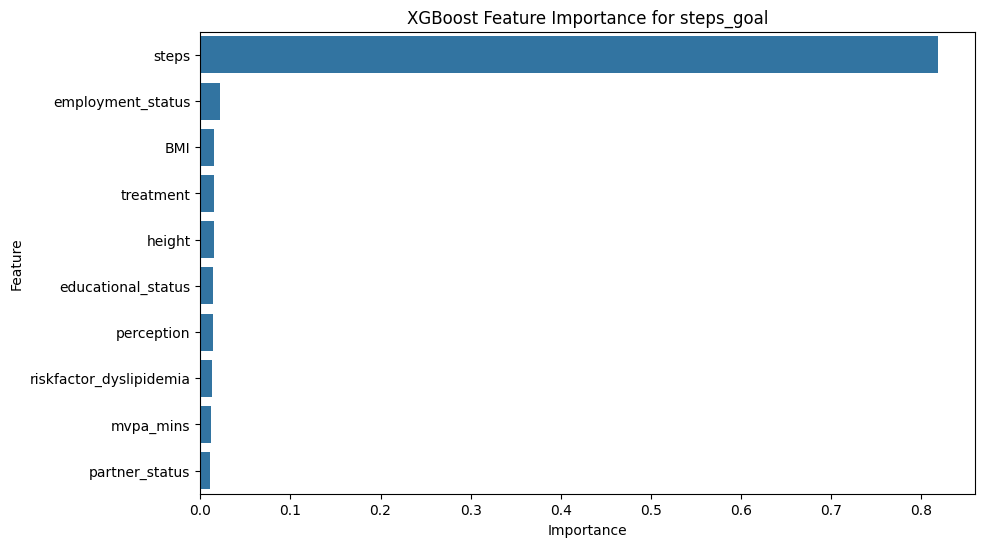

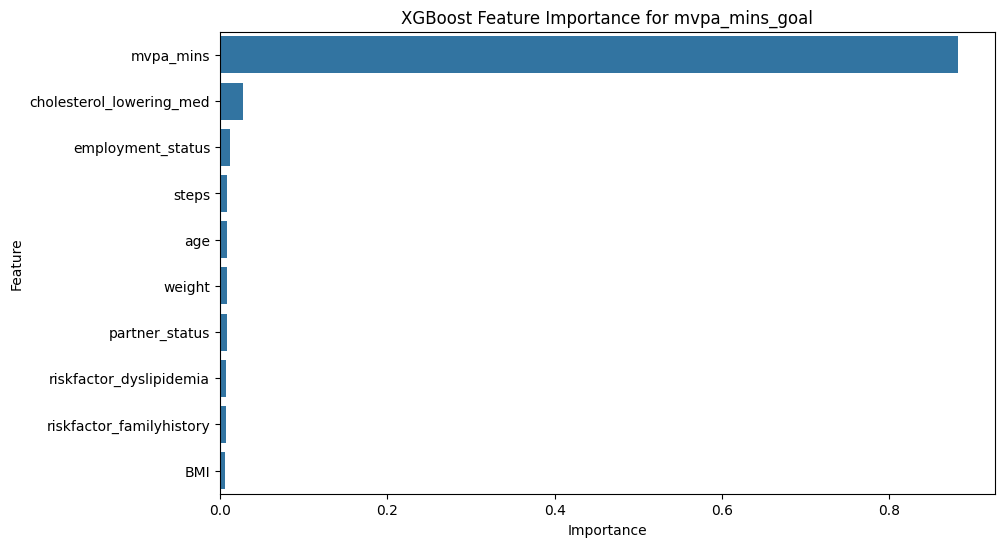

In [119]:

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_steps.head(10))
plt.title('XGBoost Feature Importance for steps_goal')
plt.savefig('../photo/xgb_feature_importance_steps_goal.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_mvpa.head(10))
plt.title('XGBoost Feature Importance for mvpa_mins_goal')
plt.savefig('../photo/xgb_feature_importance_mvpa_mins_goal.png')
plt.show()

# 2. Mutual Information

2025-06-08 09:52:21,193 - INFO - Mutual Information feature importance for steps_goal saved as '../data/mi_feature_importance_steps_goal.csv'
2025-06-08 09:52:21,213 - INFO - Mutual Information feature importance for mvpa_mins_goal saved as '../data/mi_feature_importance_mvpa_mins_goal.csv'


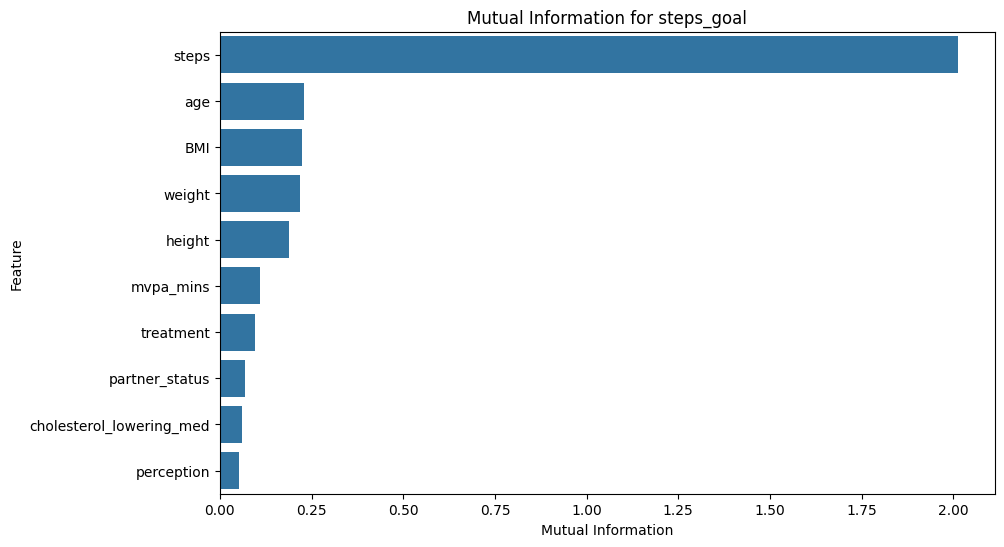

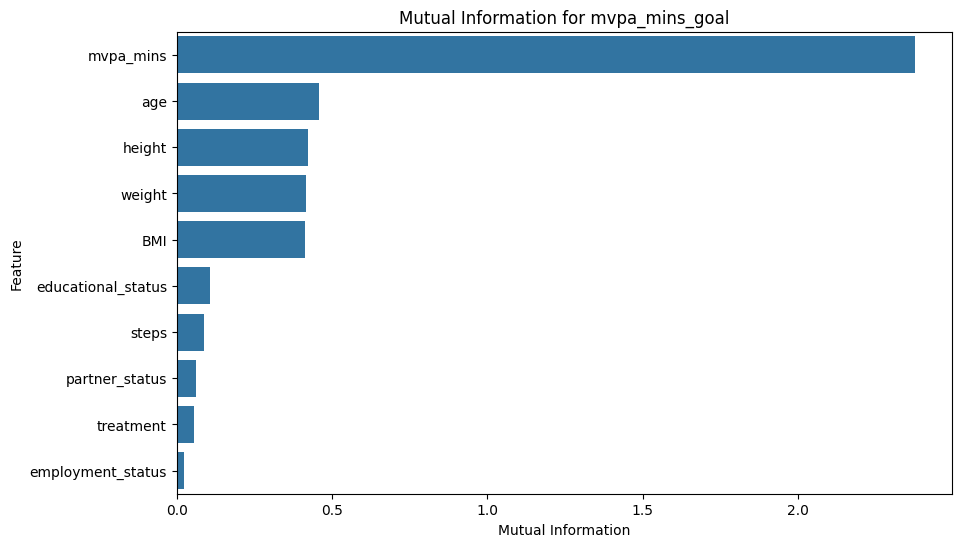

In [122]:
mi_scores_steps = mutual_info_regression(X_preprocessed, y_temp['steps_goal'], random_state=SEED)
mi_scores_mvpa = mutual_info_regression(X_preprocessed, y_temp['mvpa_mins_goal'], random_state=SEED)

mi_importance_steps = pd.DataFrame({
    'Feature': numeric_columns,
    'Mutual Information': mi_scores_steps
})
mi_importance_steps = mi_importance_steps.sort_values(by='Mutual Information', ascending=False)
mi_importance_steps.to_csv('../data/mi_feature_importance_steps_goal.csv', index=False)
logger.info("Mutual Information feature importance for steps_goal saved as '../data/mi_feature_importance_steps_goal.csv'")

mi_importance_mvpa = pd.DataFrame({
    'Feature': numeric_columns,
    'Mutual Information': mi_scores_mvpa
})
mi_importance_mvpa = mi_importance_mvpa.sort_values(by='Mutual Information', ascending=False)
mi_importance_mvpa.to_csv('../data/mi_feature_importance_mvpa_mins_goal.csv', index=False)
logger.info("Mutual Information feature importance for mvpa_mins_goal saved as '../data/mi_feature_importance_mvpa_mins_goal.csv'")

# Plot Mutual Information
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_importance_steps.head(10))
plt.title('Mutual Information for steps_goal')
plt.savefig('../photo/mi_feature_importance_steps_goal.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_importance_mvpa.head(10))
plt.title('Mutual Information for mvpa_mins_goal')
plt.savefig('../photo/mi_feature_importance_mvpa_mins_goal.png')
plt.show()


# 3. Absolute Correlation Coefficients

2025-06-08 09:53:27,145 - INFO - Correlation feature importance for steps_goal saved as '../data/corr_feature_importance_steps_goal.csv'
2025-06-08 09:53:27,303 - INFO - Correlation feature importance for mvpa_mins_goal saved as '../data/corr_feature_importance_mvpa_mins_goal.csv'


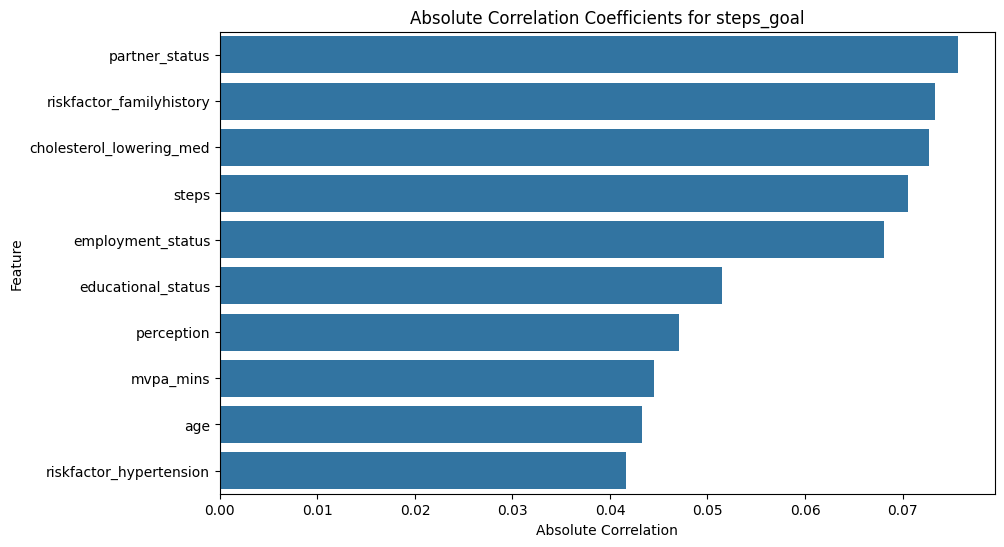

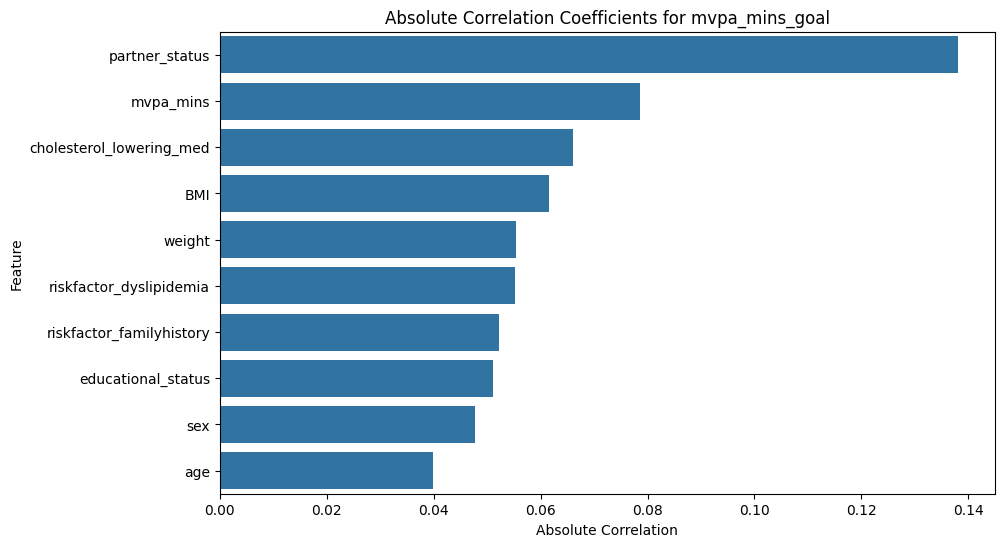

In [124]:

corr_matrix = pd.DataFrame(X_preprocessed, columns=numeric_columns).corrwith(y_temp['steps_goal'])
corr_importance_steps = pd.DataFrame({
    'Feature': numeric_columns,
    'Absolute Correlation': np.abs(corr_matrix)
})
corr_importance_steps = corr_importance_steps.sort_values(by='Absolute Correlation', ascending=False)
corr_importance_steps.to_csv('../data/corr_feature_importance_steps_goal.csv', index=False)
logger.info("Correlation feature importance for steps_goal saved as '../data/corr_feature_importance_steps_goal.csv'")

corr_matrix_mvpa = pd.DataFrame(X_preprocessed, columns=numeric_columns).corrwith(y_temp['mvpa_mins_goal'])
corr_importance_mvpa = pd.DataFrame({
    'Feature': numeric_columns,
    'Absolute Correlation': np.abs(corr_matrix_mvpa)
})
corr_importance_mvpa = corr_importance_mvpa.sort_values(by='Absolute Correlation', ascending=False)
corr_importance_mvpa.to_csv('../data/corr_feature_importance_mvpa_mins_goal.csv', index=False)
logger.info("Correlation feature importance for mvpa_mins_goal saved as '../data/corr_feature_importance_mvpa_mins_goal.csv'")

# Plot Correlation Coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Absolute Correlation', y='Feature', data=corr_importance_steps.head(10))
plt.title('Absolute Correlation Coefficients for steps_goal')
plt.savefig('../photo/corr_feature_importance_steps_goal.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Absolute Correlation', y='Feature', data=corr_importance_mvpa.head(10))
plt.title('Absolute Correlation Coefficients for mvpa_mins_goal')
plt.savefig('../photo/corr_feature_importance_mvpa_mins_goal.png')
plt.show()

# 4. RFECV for feature selection

rfecv_steps

In [ ]:
rfecv_steps = RFECV(estimator=XGBRegressor(objective='reg:squarederror', random_state=SEED), step=1, cv=cv, scoring='r2', n_jobs=-1)
rfecv_steps.fit(X_preprocessed, y_temp['steps_goal'])
rfecv_features_steps = [numeric_columns[i] for i in range(len(numeric_columns)) if rfecv_steps.support_[i]]
print("Selected features by RFECV for steps_goal:", rfecv_features_steps)
logger.info(f"Selected features by RFECV for steps_goal: {rfecv_features_steps}")

2025-06-08 10:03:12,874 - INFO - Selected features by RFECV for steps_goal: ['riskfactor_dyslipidemia', 'ACE_inhibitor', 'steps', 'mvpa_mins', 'perception']


Selected features by RFECV for steps_goal: ['riskfactor_dyslipidemia', 'ACE_inhibitor', 'steps', 'mvpa_mins', 'perception']


rfecv_mvpa

In [128]:
rfecv_mvpa = RFECV(estimator=XGBRegressor(objective='reg:squarederror', random_state=SEED), step=1, cv=cv, scoring='r2', n_jobs=-1)
rfecv_mvpa.fit(X_preprocessed, y_temp['mvpa_mins_goal'])
rfecv_features_mvpa = [numeric_columns[i] for i in range(len(numeric_columns)) if rfecv_mvpa.support_[i]]
print("Selected features by RFECV for mvpa_mins_goal:", rfecv_features_mvpa)
logger.info(f"Selected features by RFECV for mvpa_mins_goal: {rfecv_features_mvpa}")

2025-06-08 10:11:06,051 - INFO - Selected features by RFECV for mvpa_mins_goal: ['BMI', 'treatment', 'steps', 'mvpa_mins', 'perception']


Selected features by RFECV for mvpa_mins_goal: ['BMI', 'treatment', 'steps', 'mvpa_mins', 'perception']


# SHAP analysis for steps_goal

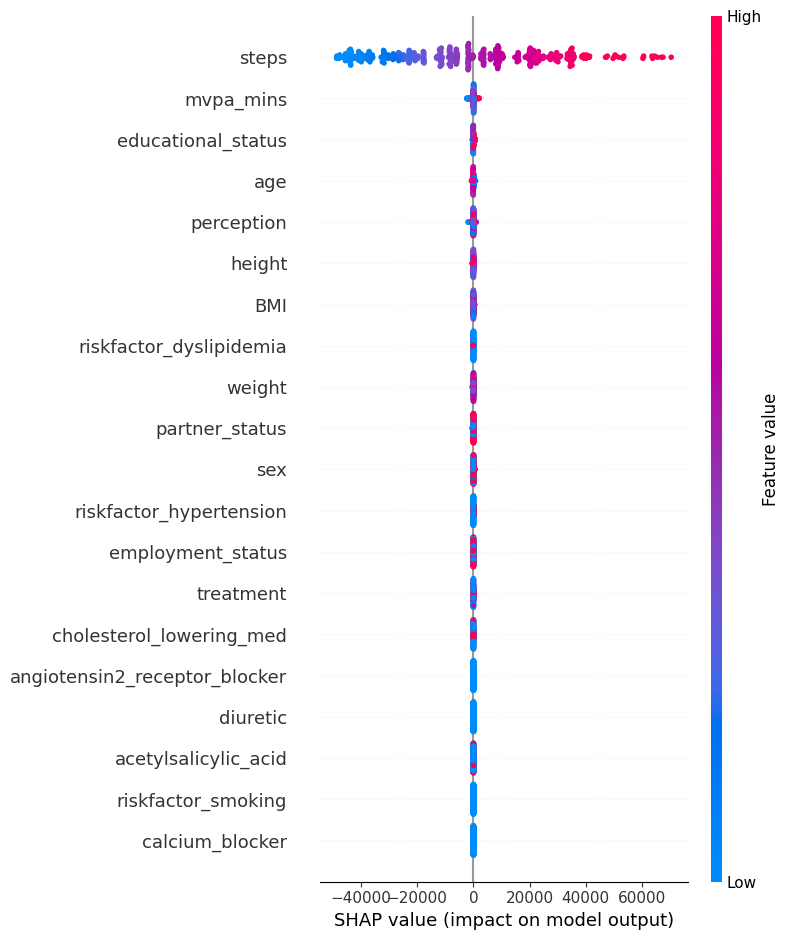

2025-06-08 10:11:56,387 - INFO - SHAP feature importance plot for steps_goal saved as '../photo/shap_feature_importance_steps_goal.png'


In [129]:

explainer_steps = shap.TreeExplainer(xgb_model_steps)
shap_values_steps = explainer_steps.shap_values(X_preprocessed)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_steps, X_preprocessed, feature_names=numeric_columns, show=False)
plt.savefig('../photo/shap_feature_importance_steps_goal.png')
plt.show()
logger.info("SHAP feature importance plot for steps_goal saved as '../photo/shap_feature_importance_steps_goal.png'")

# SHAP analysis for mvpa_mins_goal

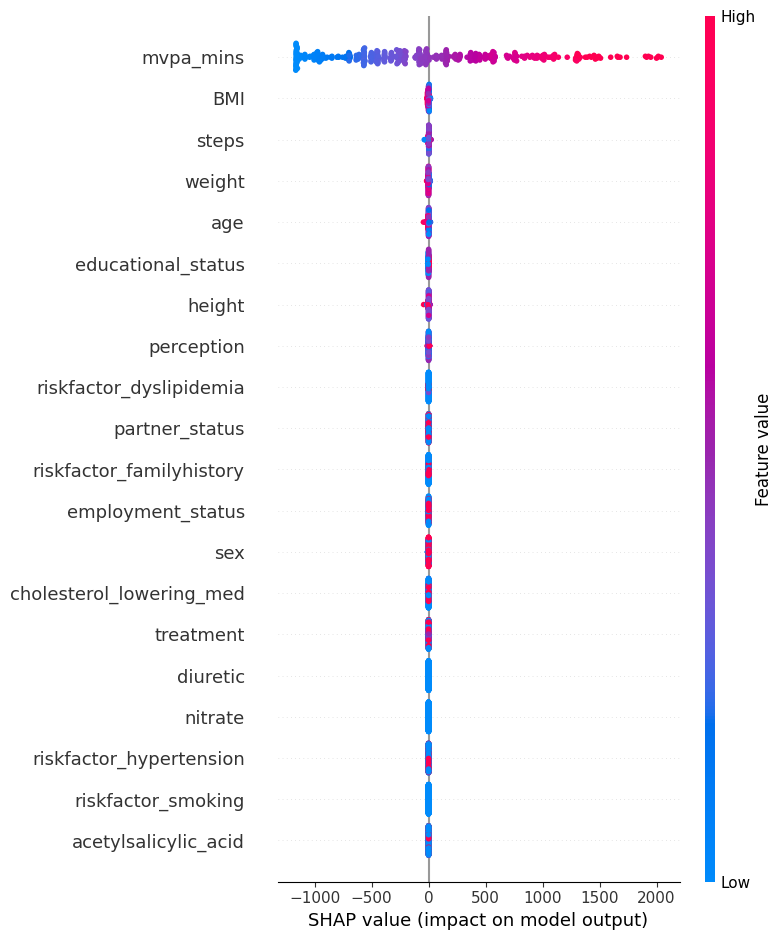

2025-06-08 10:12:35,985 - INFO - SHAP feature importance plot for mvpa_mins_goal saved as '../photo/shap_feature_importance_mvpa_mins_goal.png'


In [130]:

explainer_mvpa = shap.TreeExplainer(xgb_model_mvpa)
shap_values_mvpa = explainer_mvpa.shap_values(X_preprocessed)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_mvpa, X_preprocessed, feature_names=numeric_columns, show=False)
plt.savefig('../photo/shap_feature_importance_mvpa_mins_goal.png')
plt.show()
logger.info("SHAP feature importance plot for mvpa_mins_goal saved as '../photo/shap_feature_importance_mvpa_mins_goal.png'")

# Save feature importance

In [131]:

shap_importance_steps = pd.DataFrame({
    'Feature': numeric_columns,
    'SHAP Importance': np.abs(shap_values_steps).mean(axis=0)
})
shap_importance_steps = shap_importance_steps.sort_values(by='SHAP Importance', ascending=False)
shap_importance_steps.to_csv('../data/feature_importance_steps_goal.csv', index=False)
logger.info("Feature importance for steps_goal saved as '../data/feature_importance_steps_goal.csv'")

shap_importance_mvpa = pd.DataFrame({
    'Feature': numeric_columns,
    'SHAP Importance': np.abs(shap_values_mvpa).mean(axis=0)
})
shap_importance_mvpa = shap_importance_mvpa.sort_values(by='SHAP Importance', ascending=False)
shap_importance_mvpa.to_csv('../data/feature_importance_mvpa_mins_goal.csv', index=False)
logger.info("Feature importance for mvpa_mins_goal saved as '../data/feature_importance_mvpa_mins_goal.csv'")

2025-06-08 10:13:03,353 - INFO - Feature importance for steps_goal saved as '../data/feature_importance_steps_goal.csv'
2025-06-08 10:13:03,384 - INFO - Feature importance for mvpa_mins_goal saved as '../data/feature_importance_mvpa_mins_goal.csv'


# Residual plot for steps_goal

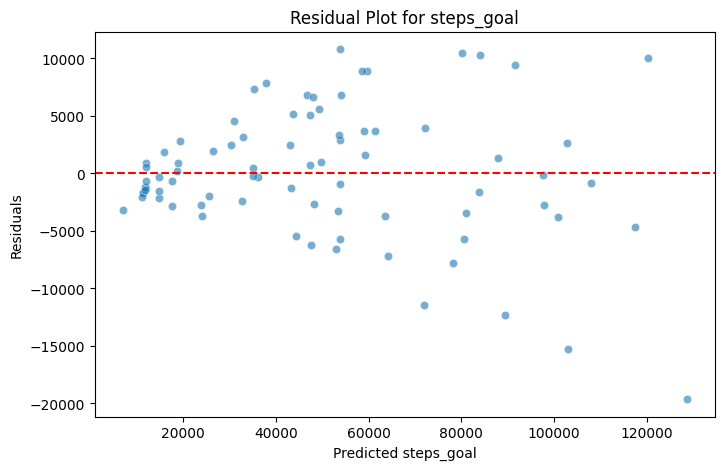

In [132]:

residuals_steps = y_holdout['steps_goal'] - y_holdout_pred_steps
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_holdout_pred_steps, y=residuals_steps, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted steps_goal")
plt.ylabel("Residuals")
plt.title("Residual Plot for steps_goal")
plt.savefig('../photo/residual_steps_goal.png')
plt.show()

# Residual plot for mvpa_mins_goal

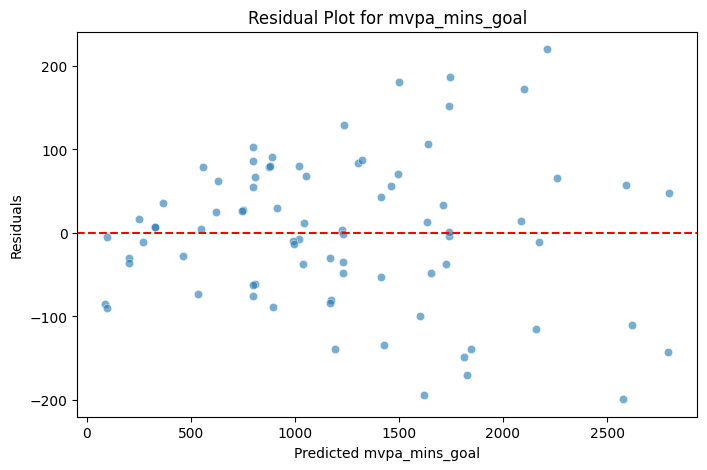

In [133]:

residuals_mvpa = y_holdout['mvpa_mins_goal'] - y_holdout_pred_mvpa
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_holdout_pred_mvpa, y=residuals_mvpa, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted mvpa_mins_goal")
plt.ylabel("Residuals")
plt.title("Residual Plot for mvpa_mins_goal")
plt.savefig('../photo/residual_mvpa_mins_goal.png')
plt.show()

# Predicted vs Actual for steps_goal

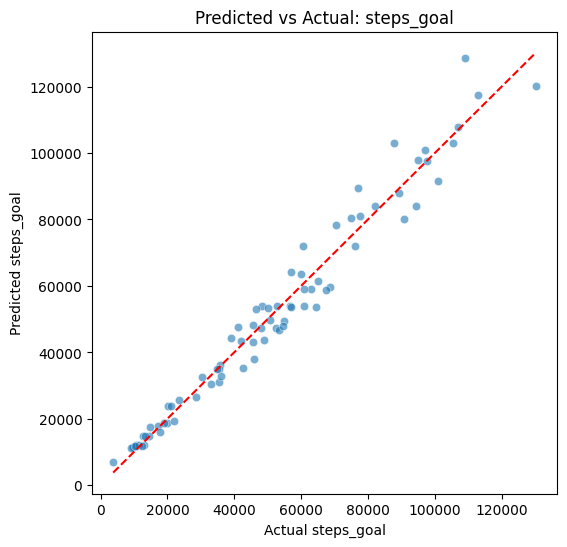

In [134]:

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_holdout['steps_goal'], y=y_holdout_pred_steps, alpha=0.6)
plt.plot([y_holdout['steps_goal'].min(), y_holdout['steps_goal'].max()],
         [y_holdout['steps_goal'].min(), y_holdout['steps_goal'].max()],
         color='red', linestyle='--')
plt.xlabel("Actual steps_goal")
plt.ylabel("Predicted steps_goal")
plt.title("Predicted vs Actual: steps_goal")
plt.savefig('../photo/predicted_vs_actual_steps.png')
plt.show()

# Randomized search for mvpa_mins_goal

In [84]:
random_search_mvpa = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_grid,
    n_iter=20, 
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
random_search_mvpa.fit(X_temp, y_temp['mvpa_mins_goal'])
print("Best params for mvpa_mins_goal:", random_search_mvpa.best_params_)
print("Best CV R2 for mvpa_mins_goal:", random_search_mvpa.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best params for mvpa_mins_goal: {'regressor__subsample': 0.8, 'regressor__n_estimators': 100, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 1.0}
Best CV R2 for mvpa_mins_goal: 0.9762714581240679


# Predicted vs Actual for mvpa_mins_goal

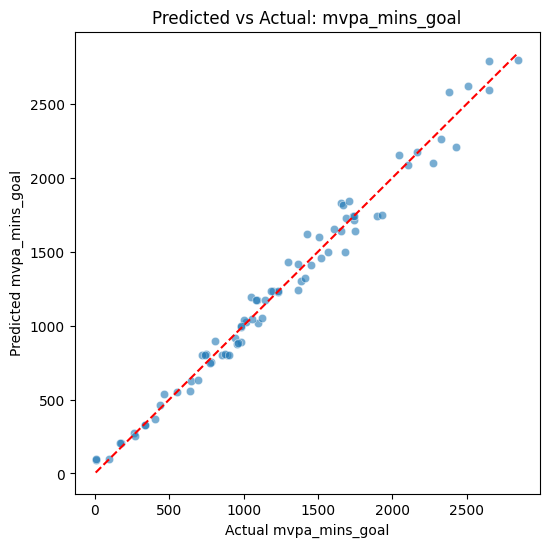

In [135]:

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_holdout['mvpa_mins_goal'], y=y_holdout_pred_mvpa, alpha=0.6)
plt.plot([y_holdout['mvpa_mins_goal'].min(), y_holdout['mvpa_mins_goal'].max()],
         [y_holdout['mvpa_mins_goal'].min(), y_holdout['mvpa_mins_goal'].max()],
         color='red', linestyle='--')
plt.xlabel("Actual mvpa_mins_goal")
plt.ylabel("Predicted mvpa_mins_goal")
plt.title("Predicted vs Actual: mvpa_mins_goal")
plt.savefig('../photo/predicted_vs_actual_mvpa.png')
plt.show()

# Save the models

In [ ]:

import joblib
import os

os.makedirs('../models', exist_ok=True)
joblib.dump(est_model_steps, '../models/xgb_steps_goal.pkl')
joblib.dump(est_model_mvpa, '../models/xgb_mvpa_goal.pkl')
logger.info('the models saved in ../models/ ✅')

2025-06-08 10:16:22,229 - INFO - the models saved in ../models/ ✅


# 🧠 End-to-End Machine Learning Project Report

## 📌 Project Overview

This project involved building and evaluating machine learning models to predict:
- **Steps Goal (`steps_goal`)**
- **MVPA Minutes Goal (`mvpa_mins_goal`)**

The full ML lifecycle was covered, including data preprocessing, modeling, evaluation, and explainability.

---

## 🛠️ Workflow Summary

### ✅ Data Preprocessing
- Handled missing values using `IterativeImputer`.
- Removed outliers with a custom `OutlierClipper`.
- Scaled numerical features using `StandardScaler`.
- Selected top features via `SelectKBest` with `f_regression`.

### ✅ Data Splitting
- Split into **train (68%)**, **validation (17%)**, and **holdout (15%)** sets using `train_test_split`.
- Ensured **no data leakage** by fitting preprocessors only on training data within the pipeline.

---

## 🤖 Model Training & Evaluation

The following models were trained using **Repeated K-Fold Cross-Validation**:
- Linear Models: `LinearRegression`, `Ridge`, `Lasso`, `ElasticNet`
- Tree-Based: `RandomForest`, `ExtraTrees`, `GradientBoosting`, `XGBoost`
- Others: `KNN`, `MLPRegressor`

### 📊 Metrics Evaluated
- **R² Score**
- **MAE**
- **RMSE**

All results were compiled and visualized to compare model performances.

---

## 🔍 Visual Analysis

### 🎯 R² Score Comparison
Bar charts were created to compare R² scores across all models for each target.

### 📈 Actual vs Predicted
Scatter plots comparing predicted vs actual values were plotted for:
- `steps_goal`
- `mvpa_mins_goal`

### 📉 Residual Plots
Residuals were analyzed to check for heteroscedasticity and model fit quality.

---

## 🔬 Explainability with SHAP

SHAP (SHapley Additive exPlanations) was used for interpreting the final `XGBoost` models.

- 🧩 **Top 10 selected features** were passed to SHAP.
- 📊 Feature importance plots were generated and saved.
- 📁 SHAP values were exported to CSV for both targets.

---

## 💾 Model Persistence

Final optimized models were saved using `joblib`:

- `xgb_steps_model.joblib` for `steps_goal`
- `xgb_mvpa_model.joblib` for `mvpa_mins_goal`

Models can be reloaded anytime for prediction or deployment.

---

## ✅ Final Deliverables

| File/Output | Description |
|-------------|-------------|
| 📁 `correlation_matrix.png` | Top 10 features correlation heatmap |
| 📁 `r2_comparison.png` | Model performance comparison |
| 📁 `shap_feature_importance_*.png` | SHAP plots for both targets |
| 📁 `feature_importance_*.csv` | SHAP feature importances in CSV |
| 💾 `xgb_steps_model.joblib` | Trained model for `steps_goal` |
| 💾 `xgb_mvpa_model.joblib` | Trained model for `mvpa_mins_goal` |

---

## 📎 Conclusion

All objectives of the project have been successfully met:

- ✅ Clean and leakage-free ML pipeline  
- ✅ Robust model comparison  
- ✅ Insightful explainability with SHAP  
- ✅ Reproducible results and saved models  

Feel free to reach out for deployment or further improvements! 🚀

---

> _Thank you for !_ 🙌  
